In [1]:
import os
from utils import load_jsonl_iteratively

root = "/data/xzhao/dataset/roman-pretrain/instructions/"

In [2]:
from collections import Counter
from tqdm import tqdm

ja_num_tokens = Counter()
for item in tqdm(load_jsonl_iteratively(os.path.join(root, "ja", "medical_native.jsonl"), request_num=3461202)):
    ja_num_tokens.update(item["llm-jp"]["token_ids"])

ja_num_tokens_low = Counter()
for item in tqdm(load_jsonl_iteratively(os.path.join(root, "ja", "medical_native_low_overlap.jsonl"), request_num=2943432)):
    ja_num_tokens_low.update(item["llm-jp"]["token_ids"])


ja_num_tokens_high = Counter()
for item in tqdm(load_jsonl_iteratively(os.path.join(root, "ja", "medical_native_high_overlap.jsonl"), request_num=3180610)):
    ja_num_tokens_high.update(item["llm-jp"]["token_ids"])

en_num_tokens = Counter()
for item in tqdm(load_jsonl_iteratively(os.path.join(root, "en_jstage", "medical_native.jsonl"), request_num=3141889)):
    en_num_tokens.update(item["llm-jp"]["token_ids"])

3461202it [01:46, 32375.50it/s]
2943432it [01:43, 28403.60it/s]
3180610it [01:46, 29770.69it/s]
3141889it [01:39, 31425.63it/s]


In [3]:
# ja_num_tokens_all = Counter()
# for item in tqdm(load_jsonl_iteratively(os.path.join(root, "ja", "medical_native.jsonl"))):
#     ja_num_tokens_all.update(item["llm-jp"]["token_ids"])


In [3]:
print("Japanese tokens:", len(ja_num_tokens))
# print("Japanese tokens all:", len(ja_num_tokens_all))
print("English tokens:", len(en_num_tokens))
print("Japanese low overlap tokens:", len(ja_num_tokens_low))
print("Japanese high overlap tokens:", len(ja_num_tokens_high))

print("------------------------------------")
print("Average frequency per Japanese token:", sum(ja_num_tokens.values()) / len(ja_num_tokens))
# print("Average frequency per Japanese all token:", sum(ja_num_tokens_all.values()) / len(ja_num_tokens_all))
print("Average frequency per English token:", sum(en_num_tokens.values()) / len(en_num_tokens))
print("Average frequency per Japanese low overlap token:", sum(ja_num_tokens_low.values()) / len(ja_num_tokens_low))
print("Average frequency per Japanese high overlap token:", sum(ja_num_tokens_high.values()) / len(ja_num_tokens_high))

Japanese tokens: 77265
English tokens: 32152
Japanese low overlap tokens: 78630
Japanese high overlap tokens: 70675
------------------------------------
Average frequency per Japanese token: 6471.242748980781
Average frequency per English token: 15551.140955461558
Average frequency per Japanese low overlap token: 6358.897049472212
Average frequency per Japanese high overlap token: 7074.622766183233


In [39]:
import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit # For fitting a power law

# Define the power-law model for the frequency of frequencies
# N(f) = A * f^(-gamma)
# where N(f) is the number of words with frequency f
def power_law_freq_dist(frequency, A, gamma):
    return A * (frequency**(-gamma))

def plot_frequency_distribution(word_counter: collections.Counter, 
                                title: str = 'Power Law for Word Frequencies'):
    """
    Plots the distribution of word frequencies:
    X-axis: Word frequency (f)
    Y-axis: Number of distinct words that have frequency f (N(f))
    Both axes are typically on a log scale.

    Args:
        word_counter: A collections.Counter object of word counts (e.g., {'the': 100, 'a': 50}).
        title: The title for the plot.
    """
    if not isinstance(word_counter, collections.Counter):
        raise TypeError("Input must be a collections.Counter object.")
    
    plt.figure(figsize=(5, 4))

    counter_of_counts = collections.Counter(word_counter.values())
    sorted_items = sorted(counter_of_counts.items())
    word_frequencies_f = np.array([item[0] for item in sorted_items], dtype=float)
    num_words_Nf = np.array([item[1] for item in sorted_items], dtype=float)

    plt.loglog(word_frequencies_f, num_words_Nf, linestyle='None', marker='o', 
               markersize=5, color='steelblue', label='Observed Distribution')

    fitted_formula_str = "Fit failed or not attempted."
    
    gamma_guess = 2.0
    A_guess = num_words_Nf[0] * (word_frequencies_f[0]**gamma_guess) if len(num_words_Nf)>0 else 1
    
    p0 = [A_guess, gamma_guess]
    # Bounds: A > 0, gamma > 0 (typically)
    bounds = ([0, 0.1], [np.inf, 5]) # Gamma usually not > 5 for this

    if len(word_frequencies_f) >= 2: # Need at least 2 points for 2 params
        params, _ = curve_fit(power_law_freq_dist, word_frequencies_f, num_words_Nf,
                                p0=p0, bounds=bounds, maxfev=5000)
        A_fit, gamma_fit = params
        
        f_fit_line = np.logspace(np.log10(min(word_frequencies_f)), 
                                    np.log10(max(word_frequencies_f)), 100)
        Nf_fit_line = power_law_freq_dist(f_fit_line, A_fit, gamma_fit)
        plt.plot(f_fit_line, Nf_fit_line, color='red', linestyle='--', 
                    label=f'Fit: N(f) ≈ {A_fit:.2e} * f^(-{gamma_fit:.2f})')
        fitted_formula_str = f'N(f) ≈ {A_fit:.2e} * f^(-{gamma_fit:.2f})'
    else:
        fitted_formula_str = "Not enough data points to fit."
    
    print(f"Fitted formula for frequency distribution: {fitted_formula_str}")

    # 5. Labels, Title, Grid, Legend
    plt.xlabel('Word Frequency [log]', fontsize=14)
    plt.ylabel('Number of Words with Frequency [log]', fontsize=14)
    plt.title(title, fontsize=16)
    plt.grid(True, which="both", ls="-", color='lightgray')
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(bottom=1)

Fitted formula for frequency distribution: N(f) ≈ 5.41e+03 * f^(-0.82)


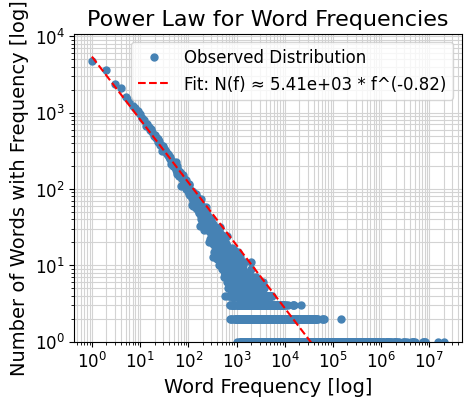

In [40]:
plot_frequency_distribution(ja_num_tokens)

Fitted formula for frequency distribution: N(f) ≈ 1.59e+03 * f^(-0.88)


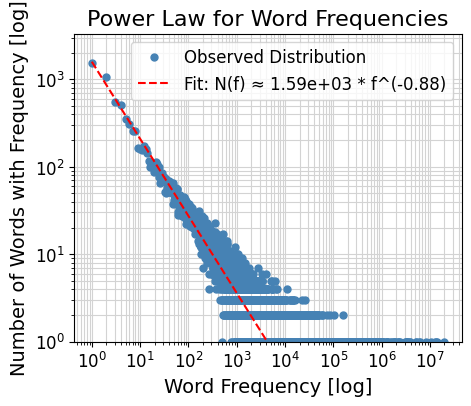

In [41]:
plot_frequency_distribution(en_num_tokens)

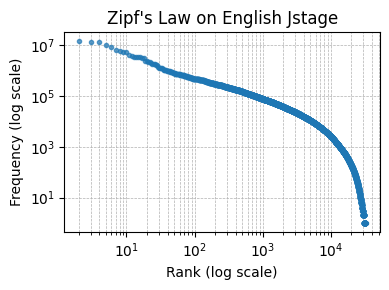

In [19]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

frequencies = np.array(sorted(en_num_tokens.values(), reverse=True))
ranks = np.arange(1, len(frequencies) + 1)
num_points = 10000 
if len(frequencies) > num_points:
    log_indices = np.unique(np.logspace(0, np.log10(len(frequencies)-1), num=num_points, dtype=int))
    ranks = ranks[log_indices]
    frequencies = frequencies[log_indices]

# Step 4: Log-log plot
plt.figure(figsize=(4, 3))
plt.loglog(ranks, frequencies, marker='.', linestyle='none', alpha=0.7)

plt.xlabel('Rank (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title("Zipf's Law on English Jstage")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()